In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import random
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import cv2

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

from itertools import count
iid = count()

SEED = 42    # random state seed for consistent results

### 0. Preprocessing

In [2]:
%%time
# mini_X = np.loadtxt("./Datasets/mini_train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/mini_train_y.csv", delimiter=",")

mini_X = np.loadtxt("./Datasets/train_med_x.csv", delimiter=",")
mini_y = np.loadtxt("./Datasets/train_med_y.csv", delimiter=",")

# mini_X = np.loadtxt("./Datasets/train_x.csv", delimiter=",")
# mini_y = np.loadtxt("./Datasets/train_y.csv", delimiter=",")

CPU times: user 8.85 s, sys: 574 ms, total: 9.43 s
Wall time: 9.52 s


#### Reshape to easily visualize while cleaning data

In [3]:
%%time
x = mini_X.reshape(-1, 64, 64)

imgs = []
for idx in range(len(x)):
    img_id = next(iid)
    cv2.imwrite('Output/{}.jpg'.format(img_id), 255-x[idx])
    imgs.append(cv2.imread('Output/{}.jpg'.format(img_id), 0))

CPU times: user 450 ms, sys: 197 ms, total: 647 ms
Wall time: 724 ms


We will first transform to binary image (black, white):

In [4]:
%%time
bin_imgs = []
for img in imgs:
    _, bin_img = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
    bin_imgs.append(bin_img)

CPU times: user 9.19 ms, sys: 36 µs, total: 9.22 ms
Wall time: 9.9 ms


Then we will remove the noice by dilatating and eroding the image:

In [5]:
%%time
denoised_imgs = []
for bin_img in bin_imgs:
    dilatated = cv2.dilate(bin_img, np.ones((3,3)))
    denoised_imgs.append(cv2.erode(dilatated, np.ones((2,2))))

CPU times: user 67.5 ms, sys: 1.89 ms, total: 69.4 ms
Wall time: 79.2 ms


Finally, find largest contour:

In [6]:
%%time
MAX_AREA = 60*60   # avoid getting the 64X64 image as a contour
def get_coords_largest_digit(contours):
    x=y=h=w=0
    max_contour = 0
    for idx, cont in enumerate(contours):
        a = cv2.contourArea(cont,False)
        if a > max_contour and a < MAX_AREA:
            x,y,w,h = cv2.boundingRect(cont)
            max_contour = a

    return x,y,w,h
 
discarted = 0
MAX_ALLOWED_LENGTH = 36
largest_digits = []
idx_to_del = []
for idx, img in enumerate(denoised_imgs.copy()):
    _, contours, _ = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    x,y,w,h = get_coords_largest_digit(contours)
    cropped_img = img[y+1:y+h, x+1:x+w]
    
    vertical = int((MAX_ALLOWED_LENGTH-h) / 2)
    horizontal = int((MAX_ALLOWED_LENGTH-w) / 2)

    if h > MAX_ALLOWED_LENGTH or w > MAX_ALLOWED_LENGTH:
        discarted +=1
        idx_to_del.append(idx)
        continue

    resized_img = cv2.copyMakeBorder(cropped_img,vertical,vertical,horizontal,horizontal,cv2.BORDER_CONSTANT, value=[255,255,255])
    largest_digits.append(resized_img[2:34,2:34])
    
mini_y = np.delete(mini_y, idx_to_del, axis=0)

print('Discarted {} samples because preprocessing failed to clean well the image.'.format(discarted))

Discarted 49 samples because preprocessing failed to clean well the image.
CPU times: user 94.8 ms, sys: 1.11 ms, total: 95.9 ms
Wall time: 99 ms


Lets visualize the transformations:

4 5


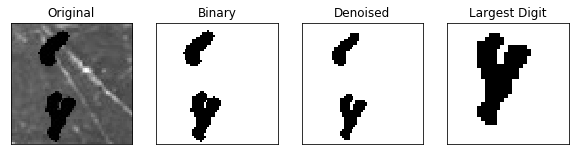

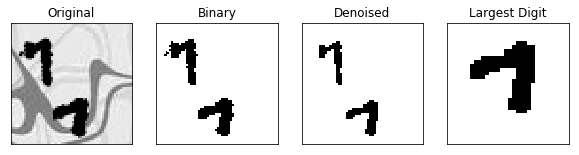

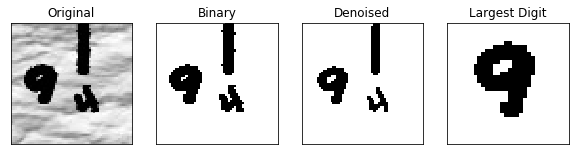

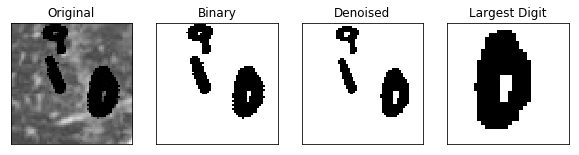

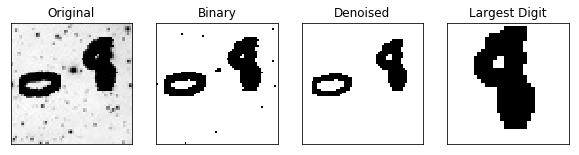

In [7]:
def plot_images(images, titles):
    cols = len(images)
    rows = len(images[0])
    
    print(cols, rows)
    for r in range(rows):
        for c in range(cols):
            plt.subplot(1,cols,c+1)
            plt.imshow(images[c][r],'gray')
            plt.title(titles[c])
            plt.xticks([]),plt.yticks([])
        
        plt.show()
        
titles = ['Original', 'Binary', 'Denoised', 'Largest Digit']
images = [imgs[:5], bin_imgs[:5], denoised_imgs[:5], largest_digits[:5]]
plot_images(images, titles)

#### Split the clean data

In [8]:
clean_X = []
for i in range(len(largest_digits)):
    clean_X.append(largest_digits[i].flatten())

clean_X = np.divide(255-np.array(clean_X),255)

mini_X_train, mini_X_test, mini_y_train, mini_y_test = train_test_split(clean_X, mini_y, 
                                                                        test_size=0.3,
                                                                       random_state=SEED)

### 1. Linear Learners

In [9]:
# %%time
# # hyperparameter permutations
# FOLDS = 3 
# DUAL = [False] 
# LOSSES = ['squared_hinge','hinge']
# PENALTIES = ['l1','l2']
# SOLVERS = ['lbfgs']

# KFOLD = KFold(n_splits=FOLDS, random_state=SEED)

#### Base and dummy clf performances for reference

In [10]:
# %%time
# # dummy clf performance
# random_clf = DummyClassifier(random_state=42)
# result = cross_val_score(random_clf, mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
# print('Random clf performance: {:.4f}'.format(result.mean()))

# # Base performance (default HP)
# result = cross_val_score(LinearSVC(), mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
# print('LinearSVM base performance: {:.4f}'.format(result.mean()))

# result = cross_val_score(LogisticRegression(), mini_X_train, mini_y_train, cv=KFOLD, scoring='accuracy')
# print('LogReg base performance: {:.4f}'.format(result.mean()))

#### Perform Model Selection for LinearSM

In [11]:
# %%time
# parameters = {'C':np.linspace(0.0005,0.001, 10)}
# svc = LinearSVC()
# clf = GridSearchCV(svc, parameters, scoring='accuracy')
# clf.fit(mini_X_train,mini_y_train)
# print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
# print('Testing Score: {:.4f}'.format(clf.score(mini_X_test, mini_y_test)))

#### Perform Model Selection for LogisticRegression

In [12]:
# %%time

# parameters = {'C':np.linspace(0.005,0.02, 10),'solver':SOLVERS,'n_jobs':[8]}
# logit = LogisticRegression()
# clf = GridSearchCV(logit, parameters, scoring='accuracy')
# clf.fit(mini_X_train,mini_y_train)
# print('HyperParameters chosen by CV: {}'.format(clf.best_params_ ))
# print('Testing Score: {:.4f}'.format(clf.score(mini_X_test, mini_y_test)))

### Convolutional Neural Network

In [111]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data

from PIL import Image

import torchvision
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split

import time
from __future__ import print_function


In [219]:
class CNN(nn.Module):
    def __init__(self, scale, batch_size):
        super(CNN, self).__init__()
        self.print = True
        self.scale = scale
        self.batch_size = batch_size
        
        self.layer1 = nn.Sequential(
        # Layer 1 14
            out1 = 37
            nn.Conv2d(in_channels=1, out_channels=out1, kernel_size=(16, 16), padding=0, stride=1),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(out1))
        
        self.layer2 = nn.Sequential(
        # Layer 2 37
            out2 = 62
            nn.Conv2d(in_channels=out1, out_channels=out2, kernel_size=(2, 2), padding=0, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(62)
        )
            
#         self.layer3 = nn.Sequential(
#         # Layer 3
#             nn.Conv2d(in_channels=37, out_channels=56, kernel_size=(1, 1), padding=0, stride=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(56),
#         )
        
#         self.layer4 = nn.Sequential(
#         # Layer 3
#             nn.Conv2d(in_channels=56, out_channels=56, kernel_size=(1, 1), padding=0, stride=1),
#             nn.ReLU(),
#             nn.BatchNorm2d(56),
#         )
        
#         self.layer5 = nn.Sequential(
#         # Layer 4
#             nn.Conv2d(in_channels=56, out_channels=37, kernel_size=(1, 1), padding=0, stride=1),
#             nn.MaxPool2d(kernel_size=(3, 3), stride=2),
#             nn.ReLU(),
#             nn.BatchNorm2d(37),
#         )
        
        
        # Logistic Regression
        self.clf = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(self.scale,self.scale),
            nn.Dropout(p=0.5),
            nn.Linear(self.scale, 10),
        )

    def forward(self, x):
        if (self.print):
            print("layer 0: ", x.shape)
        out = self.layer1(x)
        if (self.print):
            print("layer 1: ", out.shape)
        out = self.layer2(out)
        if (self.print):
            print("layer 2: ", out.shape)
#         out = self.layer3(out)
#         if (self.print):
#             print("layer 3: ", out.shape)
#         out = self.layer4(out)
#         if (self.print):
#             print("layer 4: ", out.shape)
#         out = self.layer5(out)
#         if (self.print):
#             print("layer 5: ", out.shape)
        out = out.view(out.size(0),-1)
        if (self.print):
            print("pre-linear: ", out.shape)
        out = self.clf(out)
        if (self.print):
            print("output: ", out.shape)
            self.print = False
        return out

In [220]:
import torch.utils.data as data
class DatasetKaggle(data.Dataset):
    def __init__(self, np_data_x, np_data_y, transform=None):
        self.data = np_data_x
        self.labels = np_data_y
        if (transform is not None):
            self.transform = transform
        else:
            self.transform = transforms.ToTensor()
        
    def __getitem__(self,index):
        sample = self.data[index]
        sample = sample.reshape(32,32,1)
        sample = self.transform(sample)
        
        label = int(self.labels[index])
        
        return sample, label
    
    def __len__(self):
        return len(self.labels)

In [221]:
cuda_available = torch.cuda.is_available()

train = DatasetKaggle(mini_X_train, mini_y_train)
test = DatasetKaggle(mini_X_test, mini_y_test)

batch_size = 16

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)

In [223]:
import timeit
    
clf = CNN(992, batch_size)
if cuda_available:
    clf = clf.cuda()
    
criterion = nn.CrossEntropyLoss()


weight_decays = np.logspace(-12, -2.4, num=3, endpoint=False)
learning_rates = np.logspace(-3.5, -2, num=5, endpoint=False)


optimizer = torch.optim.RMSprop(clf.parameters(), lr = .00007511886431509582, weight_decay=5e-4, momentum=0.9)
for epoch in range(100):
    start_time = timeit.default_timer()
    losses = []
    # Train
    for batch_idx, data in enumerate(trainloader):
        inputs, labels = data
        
        if (cuda_available):
            inputs, labels = inputs.cuda(), labels.cuda()
            
        inputs, labels = Variable(inputs), Variable(labels)
    
        # Reset gradients to zero
        optimizer.zero_grad()
        
        # feed forward
        outputs = clf(inputs)
        
                        
#         print("outputs: ", outputs.size())
#         print("labels: ", labels.size())
        
        
        # Compute the loss
        loss = criterion(outputs,labels)
        
        # perform a backward pass, and update the weights.
        loss.backward()
        optimizer.step()
        losses.append(loss.data[0])

    print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
    
    # Evaluate
    clf.eval()
    total = 0
    correct = 0
    for batch_idx, data in enumerate(testloader):
        inputs, labels = data
        if cuda_available:
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        outputs = clf(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
    elapsed = timeit.default_timer() - start_time
    print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
    print('Time for epoch: ', elapsed)
    print('--------------------------------------------------------------')
    clf.train()

layer 0:  torch.Size([16, 1, 32, 32])
layer 1:  torch.Size([16, 37, 8, 8])
layer 2:  torch.Size([16, 62, 4, 4])
pre-linear:  torch.Size([16, 992])
output:  torch.Size([16, 10])
Epoch : 0 Loss : 1.874 
Epoch : 0 Test Acc : 59.073
Time for epoch:  23.864410315989517
--------------------------------------------------------------
Epoch : 1 Loss : 1.440 
Epoch : 1 Test Acc : 63.707
Time for epoch:  23.310885170008987
--------------------------------------------------------------
Epoch : 2 Loss : 1.310 
Epoch : 2 Test Acc : 66.023
Time for epoch:  23.666109844023595
--------------------------------------------------------------
Epoch : 3 Loss : 1.252 
Epoch : 3 Test Acc : 68.822
Time for epoch:  22.752198190020863
--------------------------------------------------------------
Epoch : 4 Loss : 1.165 
Epoch : 4 Test Acc : 69.884
Time for epoch:  24.791574125003535
--------------------------------------------------------------
Epoch : 5 Loss : 1.107 
Epoch : 5 Test Acc : 69.595
Time for epoch: 

Process Process-5862:
Process Process-5861:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r =

KeyboardInterrupt: 

In [ ]:

# for h in learning_rates:
#     l = h
#     print("Learning rate: ", l)
# #     print("Weight Decay: ", d)
#     optimizer = torch.optim.RMSprop(clf.parameters(), lr = l, weight_decay=1e-7, momentum=0.9)
#     count = 0
#     for epoch in range(200):
#         start_time = timeit.default_timer()
#         losses = []
#         # Train
#         for batch_idx, data in enumerate(trainloader):
#             inputs, labels = data

#             if (cuda_available):
#                 inputs, labels = inputs.cuda(), labels.cuda()

#             inputs, labels = Variable(inputs), Variable(labels)

#             # Reset gradients to zero
#             optimizer.zero_grad()

#             # feed forward
#             outputs = clf(inputs)


#     #         print("outputs: ", outputs.size())
#     #         print("labels: ", labels.size())


#             # Compute the loss
#             loss = criterion(outputs,labels)

#             # perform a backward pass, and update the weights.
#             loss.backward()
#             optimizer.step()
#             losses.append(loss.data[0])
# #             print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))

#         # Evaluate
#         clf.eval()
#         total = 0
#         correct = 0
#         for batch_idx, data in enumerate(testloader):
#             inputs, labels = data
#             if cuda_available:
#                 inputs, labels = inputs.cuda(), labels.cuda()
#             inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
#             outputs = clf(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += predicted.eq(labels.data).cpu().sum()
#         elapsed = timeit.default_timer() - start_time
#         if (count%10 == 0):
#             print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
#             print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
#             print('Time for epoch ',count, ': ', elapsed)
#             print('--------------------------------------------------------------')
#         if (count == 99):
#             print('Epoch : %d Loss : %.3f ' % (epoch, np.mean(losses)))
#             print('Epoch : %d Test Acc : %.3f' % (epoch, 100.*correct/total))
#             print('Time for epoch ',count, ': ', elapsed)
#             print('--------------------------------------------------------------')
#         clf.train()
#         count += 10
